In [56]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay, plot_roc_curve

from fairlearn import datasets
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import RocAuc

In [2]:
def sensitive_pdfs(df, sensitive_features): 
    distinct_features_vals = []
    df_dict = {}
    for feature in sensitive_features:
        distinct_vals = set(df[feature].to_list())
        distinct_features_vals.append(distinct_vals)
    distinct_features_combos = list(product(*distinct_features_vals))
    for features in distinct_features_combos:
        query = " & ".join([f"{sensitive_features[i]} == '{features[i]}'" for i in range(len(sensitive_features))])
        filtered_df = df.query(query)
        key = tuple(sorted(features))
        df_dict[key] = filtered_df 
    return df_dict

In [3]:
def plot_auc(df, y_pred, y_true, name, ax=None):
    y_pred_r = np.asarray(df[y_pred]).astype(float)
    y_true_r = np.asarray(df[y_true]).astype(int)

    fpr, tpr, _ = roc_curve(y_true_r, y_pred_r, pos_label=1)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot(ax=ax)
    return display

# Load data

In [4]:
# Load data
data = datasets.fetch_adult(as_frame=True)['data']
target = datasets.fetch_adult(as_frame=True)['target']

In [73]:
assert(len(target == len(data)))
print(len(target))
print(set(target))
data.head(3)
df = data.copy()

48842
{'>50K', '<=50K'}


TypeError: 'AxesSubplot' object is not callable

# Run Model Example

In [6]:
# Extract into X, y and A
sensitive_features = ['sex', 'race']
data_cols = [x for x in data if x not in sensitive_features]

# Predictors
ohe = OneHotEncoder()
X = ohe.fit_transform(data[data_cols])

le = LabelEncoder()
y = le.fit_transform(target)
A = data[sensitive_features]

In [7]:
data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States


In [8]:
# Extract into X, y and A
sensitive_features = ['sex', 'race']
data_cols = [x for x in data if x not in sensitive_features]

# Predictors
ohe = OneHotEncoder()
X = ohe.fit_transform(data[data_cols])

le = LabelEncoder()
y = le.fit_transform(target)
A = data[sensitive_features]

# Split into test and train, making sure we have sequential indices in the results
X_train, X_test, y_train, y_test, A_train, A_test = \
    train_test_split(X, y, A, test_size=0.33, random_state=123)

# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# A_train = A_train.reset_index(drop=True)
# X_test = X_test.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)
# A_test = A_test.reset_index(drop=True)

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.923


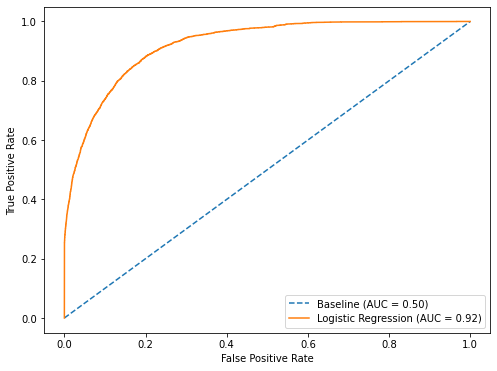

In [9]:
# Fit unmitigated model
clf = LogisticRegression(solver='liblinear', fit_intercept=True)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Get probabilies for positive prediction
y_score = y_score[:, 1]

# Get probabiliies for random (no skill)
ns_probs = [0 for n in range(len(y_test))]

# calculate AUC scores
ns_auc = roc_auc_score(y_test, ns_probs)
roc_auc = roc_auc_score(y_test, y_score)

# Summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.3f' % (roc_auc))
 
# Get overall roc curve points
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, _ = roc_curve(y_test, y_score)

# Plot ROC curve

#figure, ax = plt.subplots()
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline (AUC = 0.50)')
#display = plot_roc_curve(clf, X_test, y_test, sample_weight=None, drop_intermediate=True, response_method='auto', name="Logistic Regression", ax=ax, pos_label=1)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot(ax=ax)
plt.show()


# ROC Curves by Sensitive Values - Reference Code

In [10]:
# Concat predictions with sensitive values
y_true = y_test.copy()
pdf = pd.DataFrame({'y_true': y_true, 'y_score': y_score,'y_pred': y_pred,})
pdf = pd.concat([pdf, A_test.reset_index(drop=True)], axis=1)

# Generate grouped PDFs
# TO DO - Use metricframe class 

sensitive_pdfs_dict = sensitive_pdfs(pdf, sensitive_features)

In [11]:
sensitive_pdfs_dict[('Female',
  'Other')].head(3)

,y_true,y_score,y_pred,sex,race
297,0,0.167149,0,Female,Other
760,0,0.631803,1,Female,Other
832,0,0.001599,0,Female,Other


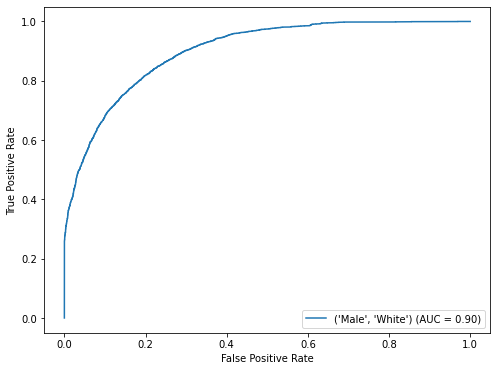

In [12]:
name = ('Male', 'White')
group = sensitive_pdfs_dict[name]
plt.figure(figsize=(8, 6))
ax = plt.gca()
group_plot = plot_auc(group,"y_score","y_true", name, ax)
plt.show()

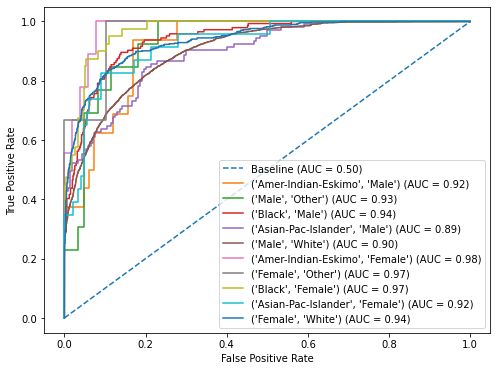

In [13]:
sensitive_pdfs_dict=sensitive_pdfs(pdf, sensitive_features)
plt.figure(figsize=(8, 6))
ax = plt.gca()
ns_probs = [0 for n in range(len(pdf))]
ns_auc = roc_auc_score(y_true, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline (AUC = 0.50)')
for grouping in sensitive_pdfs_dict: 
    group_plot = plot_auc(sensitive_pdfs_dict[grouping],"y_score", "y_true", grouping, ax)

# ROC Curves by Sensitive Values - MetricFrame

In [14]:
def splitter(y_true, y_pred=y_score):
    # Ok this is non-intuitive, but it is caused by MetricFrame requiring y_pred. 
    # Passing y_score instead does not generate an error as MetricFrame also supports regression.  
    return (y_true, y_pred)

In [15]:
def plot_auc(y_true, y_score, name, ax=None, pos_label=1, **kwargs):
    """
    Plot auc curves. 
    """
    fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=pos_label, **kwargs)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot(ax=ax)
    return display

In [16]:
roc_auc

0.9228475501209812

In [17]:
# Hmm. Passing y_score as y_pred could lead to issues later... but... 
mf = MetricFrame(splitter, y_true, y_pred=y_score, sensitive_features=A_test,
                 #sample_params = {'y_score': y_score}
                )
sensitive_series = mf.by_group

In [18]:
sensitive_series.index

MultiIndex([('Female', 'Amer-Indian-Eskimo'),
            ('Female', 'Asian-Pac-Islander'),
            ('Female',              'Black'),
            ('Female',              'Other'),
            ('Female',              'White'),
            (  'Male', 'Amer-Indian-Eskimo'),
            (  'Male', 'Asian-Pac-Islander'),
            (  'Male',              'Black'),
            (  'Male',              'Other'),
            (  'Male',              'White')],
           names=['sex', 'race'])

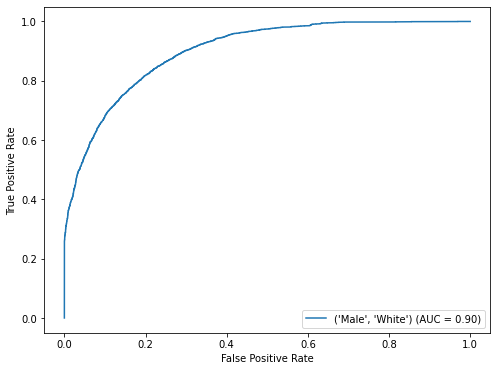

In [19]:
name = ('Male', 'White')
grp = sensitive_series[name]
grp_y_true = sensitive_series[name][0]
grp_y_score = sensitive_series[name][1]
plt.figure(figsize=(8, 6))
ax = plt.gca()
group_plot = plot_auc(y_true=grp_y_true, y_score=grp_y_score, name=name, ax=ax)
plt.show()

In [20]:
vars(group_plot)

{'estimator_name': ('Male', 'White'),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99366208, 0.99397125,
        1.        ]),
 'tpr': array([0.00000000e+00, 3.33667000e-04, 2.35235235e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'roc_auc': 0.9008740280446366,
 'pos_label': None,
 'line_': <matplotlib.lines.Line2D at 0x1228c1190>,
 'ax_': <AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 'figure_': <Figure size 576x432 with 1 Axes>}

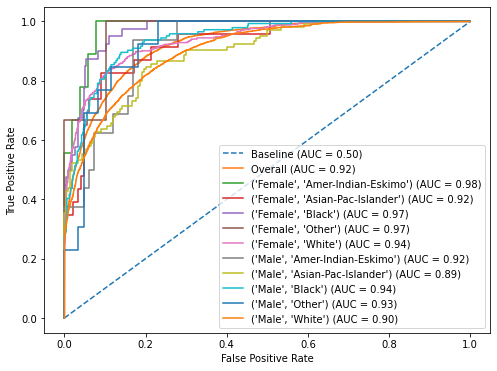

In [21]:
# Establish plot figure
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot baseline - 'no skill'
# i.e. performance of classifier is equivalent to random selection
ns_probs = [0 for n in range(len(pdf))]
ns_auc = roc_auc_score(y_true, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline (AUC = 0.50)')

# Plot overall model performance
overall_auc = roc_auc_score(y_true, y_score)
overall_fpr, overall_tpr, _ = roc_curve(y_true, y_score)
ax.plot(overall_fpr, overall_tpr, label=f'Overall (AUC = {round(overall_auc, 2)})')

# Plot ROC Curves by group
for name in sensitive_series.index: 
    grp = sensitive_series[name]
    grp_y_true = sensitive_series[name][0]
    grp_y_score = sensitive_series[name][1]
    group_plot = plot_auc(y_true=grp_y_true, y_score=grp_y_score, name=name, ax=ax)
plt.show()

In [22]:
group_plot.ax_

<AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [50]:
vars(group_plot)

{'estimator_name': ('Male', 'White'),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99366208, 0.99397125,
        1.        ]),
 'tpr': array([0.00000000e+00, 3.33667000e-04, 2.35235235e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'roc_auc': 0.9008740280446366,
 'pos_label': None,
 'line_': <matplotlib.lines.Line2D at 0x12467d070>,
 'ax_': <AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 'figure_': <Figure size 576x432 with 1 Axes>}

# ROC AUC

In [23]:
type(y_true)

numpy.ndarray

In [44]:
class roc_auc: 
    """
    Provides utilties for generating AUC scores, ROC curves
    and plotting ROC curves grouped by sensitive feature. Depends on 
    the Fairlearn MetricFrame class to split the input by sensitive feature. Uses the standard 
    Scikit-learn modules `roc_curve`, `auc`, `roc_auc_score` to compute the false positive
    rate, true positive rate and area under the curve (AUC) respectively. Passing keyword 
    arguemnts to class methods will pass those parameters to the underlying 
    Scikit-learn function to allow for greater control. 
    
    Reference: 
    MetricFrame : https://fairlearn.org/v0.6.2/api_reference/fairlearn.metrics.html
    auc : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html?highlight=auc#sklearn.metrics.auc
    roc_auc_score : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    RocCurveDisplay : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay
    
    
    Parameters
    ----------
    y_true : List, pandas.Series, numpy.ndarray, pandas.DataFrame
    The ground-truth labels for classification. (i.e. results of clf.predict())
    If labels are not either {-1, 1} or {0, 1}, then pos_label should be 
    explicitly given.
        
    y_score : List, pandas.Series, numpy.ndarray, pandas.DataFrame
    Target scores, can either be probability estimates of the positive
    class, confidence values, or non-thresholded measure of decisions
    (as returned by "decision_function" on some classifiers).
        
    sensitive_features : List, pandas.Series, dict of 1d arrays, numpy.ndarray, pandas.DataFrame
        The sensitive features which should be used to create the subgroups.
        At least one sensitive feature must be provided.
        All names (whether on pandas objects or dictionary keys) must be strings.
        We also forbid DataFrames with column names of ``None``.
        For cases where no names are provided we generate names ``sensitive_feature_[n]``.
        
    """
    def __init__(self,
                 y_true, 
                 y_score, 
                 sensitive_features): 
        """
        Initiate class with required parameters to generate metric. 
        
        Parameters
        ----------
        y_true : List, pandas.Series, numpy.ndarray, pandas.DataFrame
        
        y_score : List, pandas.Series, numpy.ndarray, pandas.DataFrame
                
        """
        self.y_true = y_true
        self.y_score = y_score 
        self.sensitive_features = sensitive_features
        self.sensitive_series = self.by_group()
        
    @staticmethod
    def splitter(y_true, y_pred): 
        """
        Placeholder function to enable splitting of dataframes using 
        existing MetricFrame class which requires a metric. 
        """
        return (y_true, y_pred)
    
    @staticmethod
    def plot_roc(y_true, y_score, name=None, ax=None, pos_label=1, **kwargs):
        """
        Plot Roc Curves. 
        
           
        Parameters
        ----------
        y_true : List, pandas.Series, numpy.ndarray, pandas.DataFrame
        
        y_score : List, pandas.Series, numpy.ndarray, pandas.DataFrame
        
        name : The name to be used to populate the legend of the axes if provided.  
        
        pos_label : The label of the positive class. When pos_label=None, if y_true is in 
        {-1, 1} or {0, 1}, pos_label is set to 1, otherwise an error will be raised.
        
        **kwargs : Optional additional key word arguments to pass to the Scikit-learn 
        method roc_curve.  See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

        Returns
        -------
        display : sklearn.metrics._plot.roc_curve.RocCurveDisplay object populated with data values as returned by
        the Scikit-learn module `RocCurveDisplay.` Contains the following: 'estimator_name', 
        'fpr', 'tpr', 'roc_auc', 'pos_label', 'line_', 'ax_', 'figure_'. 
        
        """      
        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=pos_label, **kwargs)
        auc_score = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name=name)
        display.plot(ax=ax)
        return display
    
    def plot_baseline(self, ax=None, name='Baseline'): 
        """
        Plot baseline indicator. Adds an optional axes to include a 
        baseline axes on the plot representing selection at random for 
        comparison. 
        """
        
        # Generate plot figure, ax if not provided    
        if not ax: 
            figure, ax = plt.subplots()
        
        # Plot baseline - 'no skill'
        # i.e. performance of classifier is equivalent to random selection
        ns_probs = [0 for n in range(len(self.y_true))]
        baseline_auc = roc_auc_score(self.y_true, ns_probs)
        ns_fpr, ns_tpr, _ = roc_curve(self.y_true, ns_probs)
        ax.plot(
            ns_fpr, 
            ns_tpr, 
            linestyle='--',
            color='0.8',
            label=f'{name} (AUC = {round(baseline_auc, 2)})'
               )
        return ax
    
    def plot_overall(self, ax=None, name='Overall', pos_label=1, **kwargs): 
        """
        Plot the overall performance of the model. Adds an optional axes to plot the overall 
        ROC curve for the data as a whole. 
        
        Parameters
        ----------
        ax : A Matplotlib axes object. 
        
        name : The name to set as the label of the axes. Default is "Overall". 
        
        pos_label : The label of the positive class. When pos_label=None, if y_true is in 
        {-1, 1} or {0, 1}, pos_label is set to 1, otherwise an error will be raised.
        
        **kwargs : Optional additional key word arguments to pass to the Scikit-learn 
        method roc_curve.  See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
        
        Returns
        -------
        ax : The Matplotlib axes object with data values added to the axes. If using
        the default, the axes will also include the default legend label 
        (i.e. "Overall (AUC = 0.92)")
        
        """
        # Generate plot figure, ax if not provided    
        if not ax: 
            figure, ax = plt.subplots()
            
        # Plot overall model performance 
        self.overall_auc = roc_auc_score(self.y_true, self.y_score)
        overall_fpr, overall_tpr, _ = roc_curve(
            self.y_true, 
            self.y_score, 
            pos_label=pos_label, 
            **kwargs
        )
        label=f'{name} (AUC = {round(self.overall_auc, 2)})'
        ax.plot(overall_fpr, overall_tpr, label=label)
        return ax 
    
    def by_group(self): 
        """
        Splits data by sensitive feature subgroups. 
        See: fairlearn.MetricFrame for more detail. 
        
        Note: MetricFrame requires y_pred (clf.predict). However, ROC curves and AUC scores 
        are generated using y_score (clf.predict_proba). 
        This method substitutes y_score (type:float) for y_pred (type:int) to conform to MetricFrame 
        required params.  
        (MetricFrame supports both regression and therefore allows values of type float to be 
        passed as y_pred.) 

        Returns
        -------
        self.sensitive_series : Pandas Series object containing `y_true` and `y_score`
        indexed by sensitive feature. 
  
        """
        mf = MetricFrame(
            metric = self.splitter, 
            y_true = self.y_true, 
            y_pred = self.y_score, 
            sensitive_features = self.sensitive_features,
                        )
        self.sensitive_series = mf.by_group
        return self.sensitive_series
    
    def plot_by_group(
        self, 
        sensitive_index=None, 
        title = None,
        ax=None, 
        include_overall=True,
        include_baseline=True, 
        pos_label=1,
        **kwargs
                ): 
        """
        Plots ROC curve by sensitive feature subgroup. 
        
        To enable sub-groupings of sensitive features to be plotted separately and allow for more readable plots,
        the user may select specific features to plot. The object the user passes must be 
        a Series index as returned by the `by_group` method. By default the legend labels will 
        be the name included in the index for each sensitive feature subgrouping in the form of a tuple. 
        The plot can be customized by passing an axes object to the `ax` parameter. 
        
        See example. 
        
        Parameters
        ----------
        
        sensitive_index : Optional Pandas Series object that contains the data associated with the sensitive feature 
        indexed by subgroup. If not provided, defaults to all groups in the series index. 
        
        title : Optional title to add to the resulting figure. Typically the name of the estimator (i.e. 'Logistic Regression')
        used for classification.  
        
        ax : A Matplotlib axes object. 
        
        include_overall : Whether to include a plot of the ROC curve for the data as a whole for comparison. 
        Default is true.
        
        include_baseline : Whether to include a baseline (i.e. selection at random) for comparison. 
        Defaults to true. 
        
        pos_label : The label of the positive class. When pos_label=None, if y_true is in 
        {-1, 1} or {0, 1}, pos_label is set to 1, otherwise an error will be raised.
        
        **kwargs : Optional additional key word arguments to pass to the Scikit-learn 
        method roc_curve.  See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
        
        Returns
        -------
        ax : The Matplotlib axes object with data values added to the axes. If using
        the default, the axes will also include the default legend label 
        (i.e. "Overall (AUC = 0.92)")
        
        
        """
        # Establish sensitive features            
        if not sensitive_index: 
            sensitive_index = self.sensitive_series.index
            
        # Generate plot figure, ax if not provided    
        if not ax: 
            figure, ax = plt.subplots()
            
        # Set plot title to name of estimator 
        if title: 
            ax.set_title(title)
            
        # Plot baseline
        if include_baseline: 
            ax = self.plot_baseline(ax=ax)
        
        # Plot overall
        if include_overall: 
            ax = self.plot_overall(ax=ax)

        # Plot ROC Curves by group
        for name in sensitive_index: 
            grp = self.sensitive_series[name]
            grp_y_true = self.sensitive_series[name][0]
            grp_y_score = self.sensitive_series[name][1]
            group_plot = self.plot_roc(
                y_true=grp_y_true, 
                y_score=grp_y_score, 
                name=name, #apply subgroup name to legend label
                ax=ax, 
                pos_label=pos_label, 
                **kwargs
            )
     
        return ax 
    
    def auc_by_group(self, sensitive_index=None): 
        """
        Calculates AUC score by sensitive feature subgroups. 
        To enable sub-groupings of sensitive features, the user may select 
        specific features to plot. 
        
        Parameters
        ----------
        sensitive_index : Optional Pandas Series object that contains the data associated with the sensitive feature 
            indexed by subgroup. If not provided, defaults to all groups in the series index.

        Returns
        -------
        self.auc_scores : The auc scores computed by sensitive feature groups. Also stored as a class
            object. 
        
        """
        # Establish sensitive features
        if not sensitive_index: 
            sensitive_index = self.sensitive_series.index
            
        self.auc_scores = {}
        for name in sensitive_index:
            grp = self.sensitive_series[name]
            grp_y_true = self.sensitive_series[name][0]
            grp_y_score = self.sensitive_series[name][1]
            grp_score = roc_auc_score(grp_y_true, grp_y_score)
            self.auc_scores[name] = grp_score 
        return self.auc_scores
        

## Default - No figure

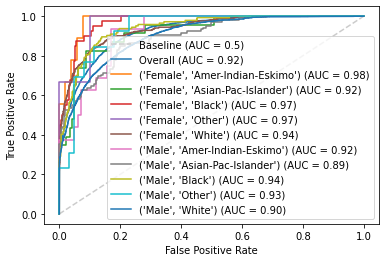

In [62]:
# Plot ROC curves by group
rc = RocAuc(y_true, y_score, A_test)
rc.plot_by_group()
plt.show()

## Default - Existing Figure

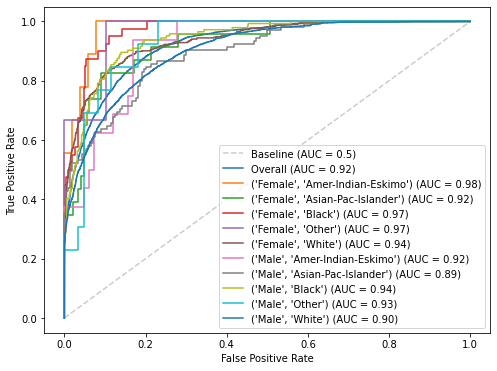

In [63]:
# Establish plot figure
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot ROC curves by group
rc = roc_auc(y_true, y_score, A_test)
rc.plot_by_group(ax=ax)
plt.show()

# Plot - Configued w/ Parameters

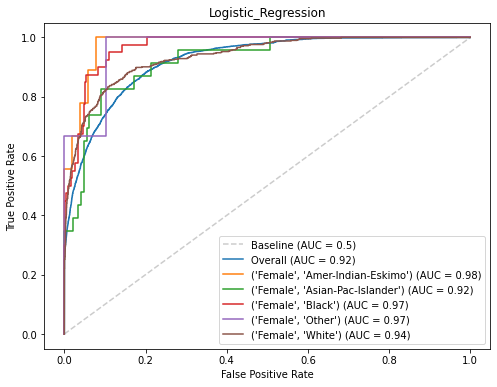

In [67]:
# Establish plot figure
plt.figure(figsize=(8, 6))
ax = plt.gca()

rc = roc_auc(y_true, y_score, A_test)
by_group = rc.by_group()
female_only = [x for x in by_group.index if 'Female' in x]
rc.plot_by_group( 
    sensitive_index=female_only, 
    title = "Logistic_Regression",
    ax=ax,
    include_overall=True,
    include_baseline=True,
)
plt.show()

In [71]:
auc_scores = rc.auc_by_group()
auc_scores

{('Female', 'Amer-Indian-Eskimo'): 0.9782135076252724,
 ('Female', 'Asian-Pac-Islander'): 0.9237641453245979,
 ('Female', 'Black'): 0.9689024390243902,
 ('Female', 'Other'): 0.9659863945578231,
 ('Female', 'White'): 0.9360880134378032,
 ('Male', 'Amer-Indian-Eskimo'): 0.9179216867469879,
 ('Male', 'Asian-Pac-Islander'): 0.8942403628117914,
 ('Male', 'Black'): 0.9402619949494949,
 ('Male', 'Other'): 0.9319041614123581,
 ('Male', 'White'): 0.9008740280446366}

In [72]:
auc_scores_female = rc.auc_by_group(female_only)
auc_scores_female

{('Female', 'Amer-Indian-Eskimo'): 0.9782135076252724,
 ('Female', 'Asian-Pac-Islander'): 0.9237641453245979,
 ('Female', 'Black'): 0.9689024390243902,
 ('Female', 'Other'): 0.9659863945578231,
 ('Female', 'White'): 0.9360880134378032}